In [1]:
import findspark, pyspark

from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

In [2]:
import os
import shutil

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [3]:
import nltk

nltk.download("wordnet")

from nltk.stem import WordNetLemmatizer

# Lemmatization reduces the words to their root or base forms, known as lemma. It was performed by WordNetLemmatizer() from the nltk.stem module. The lemmatizer called the lemmatize() function on each token present in the text and then combined the results.


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/felipesilva/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
from pyspark.ml import Pipeline, Transformer, PipelineModel
from pyspark.ml.feature import RegexTokenizer # tokenizer
from pyspark.ml.feature import HashingTF, IDF # vectorizer
from pyspark.ml.feature import StopWordsRemover # to remove stop words
from pyspark.ml.classification import LogisticRegression, LinearSVC, OneVsRest, NaiveBayes # ml models
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable
from pyspark.ml.param.shared import HasInputCol, HasOutputCol
from pyspark.ml.evaluation import MulticlassClassificationEvaluator # to evaluate the model
from pyspark.mllib.evaluation import MulticlassMetrics # # performance metrics

In [5]:
# Create the Spark session

findspark.init()
findspark.find()

spark = SparkSession\
        .builder\
        .appName("ADBFinacialReportsSecModelEvaluation")\
        .config("spark.sql.shuffle.partitions",200)\
        .config("spark.driver.memory", "16G")\
        .config("spark.executor.memory", "16G")\
        .config("spark.executor.cores", "4")\
        .config("spark.driver.maxResultSize", "8G")\
        .config("spark.sql.repl.eagereval.enabled",True)\
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer")\
        .config("spark.kryoserializer.buffer.max", "512m")\
        .config("spark.default.parallelism", 200)\
        .getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/02 22:26:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [7]:
data_dir = "../Datasets/financial-reports-sec/parquet/large/"
pipelines_path = "pipelines/"
pipelines_model_path = "pipelines_model/"

In [8]:
def get_confusion_matrix_data(predictions):
  # important: need to cast to float type, and order by prediction, else it won't work
  preds_and_labels = predictions.select(['prediction','label']) \
    .withColumn('label', F.col('label') \
    .cast(FloatType())) \
    .orderBy('prediction')
  
  # generate metrics
  metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
  metrics_arr = metrics.confusionMatrix().toArray()

  return metrics_arr / np.sum(metrics_arr)

def plot_cofusion_matrix(data, title):
  
  # figure object
  fig, ax = plt.subplots(1, 1, figsize=(7, 7))

  # plot confusion matrix
  sns.heatmap(data, cmap='Blues', annot=True, fmt='.2%', ax=ax, square=True)
  
  fig.suptitle(title, fontsize=16)
  ax.set(xlabel="Predicted Label", ylabel="True Label")
  
  plt.tight_layout()
  plt.show()

def evaluation_metrics(predictions):
  # List of metrics to evaluate
  metrics = ["accuracy", "weightedPrecision", "weightedRecall", "f1"]

  # Initialize evaluator
  evaluator = MulticlassClassificationEvaluator()
  results = {}

  # Evaluate and collect each metric
  for metric in metrics:
    evaluator.setMetricName(metric)
    score = evaluator.evaluate(predictions)
    results[metric] = score

  return results

In [9]:
class Lemmatizer(Transformer, HasInputCol, HasOutputCol, DefaultParamsReadable, DefaultParamsWritable):
  def __init__(self, inputCol=None, outputCol=None):
    super(Lemmatizer, self).__init__()
    self.lemmatizer = WordNetLemmatizer()
    self._setDefault(inputCol=inputCol, outputCol=outputCol)
    self._set(inputCol=inputCol, outputCol=outputCol)
  
  def _transform(self, df):
    lemmatize_udf = F.udf(lambda words: [self.lemmatizer.lemmatize(word) for word in words], ArrayType(StringType()))
    return df.withColumn(self.getOutputCol(), lemmatize_udf(df[self.getInputCol()]))

In [10]:
df_test = spark.read.parquet(data_dir + "test.parquet")
df_train = spark.read.parquet(data_dir + "train.parquet")

In [11]:
pipeline = PipelineModel.load(f"{pipelines_model_path}LogisticRegression")
predictions = pipeline.transform(df_test)
metrics = evaluation_metrics(predictions)
cm_data = get_confusion_matrix_data(predictions)

24/06/02 21:14:14 WARN DAGScheduler: Broadcasting large task binary with size 15.4 MiB
24/06/02 21:14:47 WARN DAGScheduler: Broadcasting large task binary with size 15.4 MiB
24/06/02 21:15:09 WARN DAGScheduler: Broadcasting large task binary with size 15.4 MiB
24/06/02 21:15:31 WARN DAGScheduler: Broadcasting large task binary with size 15.4 MiB
24/06/02 21:15:53 WARN DAGScheduler: Broadcasting large task binary with size 15.4 MiB
24/06/02 21:16:14 WARN DAGScheduler: Broadcasting large task binary with size 15.4 MiB
24/06/02 21:16:35 WARN DAGScheduler: Broadcasting large task binary with size 15.4 MiB
24/06/02 21:16:35 WARN DAGScheduler: Broadcasting large task binary with size 15.4 MiB


LogisticRegression Metrics:

Accuracy: 0.22161687170474517
Weightedprecision: 0.2099730316732892
Weightedrecall: 0.22161687170474517
F1: 0.21518135011324235


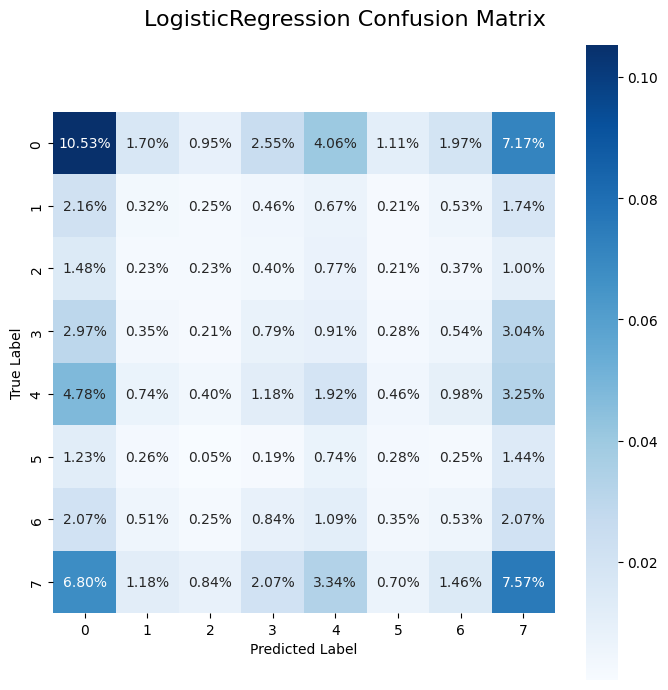

In [12]:
print("LogisticRegression Metrics:\n")
for metric, score in metrics.items():
  print(f"{metric.capitalize()}: {score}")

plot_cofusion_matrix(cm_data, "LogisticRegression Confusion Matrix")

In [11]:
pipeline = PipelineModel.load(f"{pipelines_model_path}LogisticRegression_Lemmatized")
predictions = pipeline.transform(df_test)
metrics = evaluation_metrics(predictions)
cm_data = get_confusion_matrix_data(predictions)

24/06/02 21:18:37 WARN DAGScheduler: Broadcasting large task binary with size 15.3 MiB
24/06/02 21:20:22 WARN DAGScheduler: Broadcasting large task binary with size 15.3 MiB
24/06/02 21:21:59 WARN DAGScheduler: Broadcasting large task binary with size 15.3 MiB
24/06/02 21:23:35 WARN DAGScheduler: Broadcasting large task binary with size 15.3 MiB
24/06/02 21:25:14 WARN DAGScheduler: Broadcasting large task binary with size 15.3 MiB
24/06/02 21:26:51 WARN DAGScheduler: Broadcasting large task binary with size 15.3 MiB
24/06/02 21:28:28 WARN DAGScheduler: Broadcasting large task binary with size 15.3 MiB
24/06/02 21:28:28 WARN DAGScheduler: Broadcasting large task binary with size 15.3 MiB


LogisticRegression Lemmatized Metrics:

Accuracy: 0.22056239015817222
Weightedprecision: 0.2108297262781504
Weightedrecall: 0.22056239015817222
F1: 0.21519520115666144


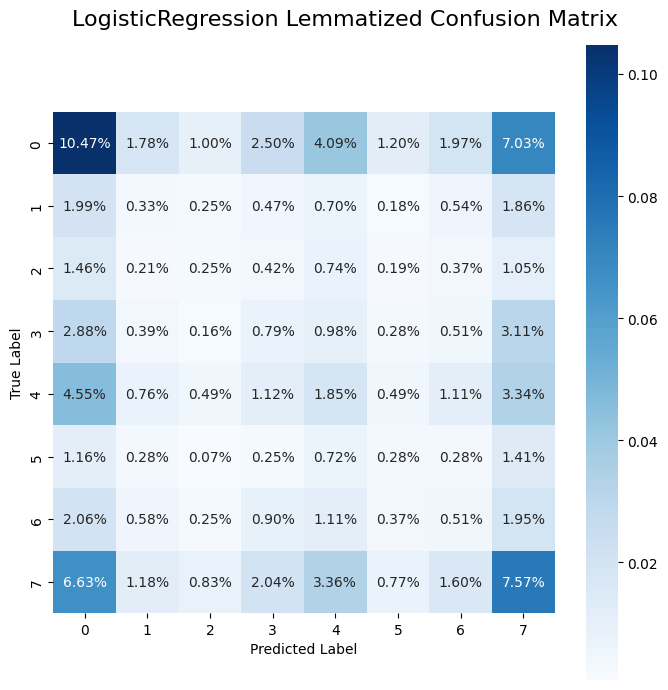

In [12]:
print("LogisticRegression Lemmatized Metrics:\n")
for metric, score in metrics.items():
  print(f"{metric.capitalize()}: {score}")

plot_cofusion_matrix(cm_data, "LogisticRegression Lemmatized Confusion Matrix")

In [11]:
pipeline = PipelineModel.load(f"{pipelines_model_path}LinearSVC")
predictions = pipeline.transform(df_test)
metrics = evaluation_metrics(predictions)
cm_data = get_confusion_matrix_data(predictions)

24/06/02 22:19:21 WARN DAGScheduler: Broadcasting large task binary with size 15.4 MiB
24/06/02 22:20:07 WARN DAGScheduler: Broadcasting large task binary with size 15.4 MiB
24/06/02 22:20:47 WARN DAGScheduler: Broadcasting large task binary with size 15.4 MiB
24/06/02 22:21:26 WARN DAGScheduler: Broadcasting large task binary with size 15.4 MiB
24/06/02 22:22:05 WARN DAGScheduler: Broadcasting large task binary with size 15.4 MiB
24/06/02 22:22:44 WARN DAGScheduler: Broadcasting large task binary with size 15.4 MiB
24/06/02 22:23:06 WARN DAGScheduler: Broadcasting large task binary with size 15.4 MiB
24/06/02 22:23:45 WARN DAGScheduler: Broadcasting large task binary with size 15.4 MiB
24/06/02 22:23:46 WARN DAGScheduler: Broadcasting large task binary with size 15.4 MiB


LinearSVC Metrics:

Accuracy: 0.21933216168717048
Weightedprecision: 0.21164456322442235
Weightedrecall: 0.21933216168717048
F1: 0.21524790556113976


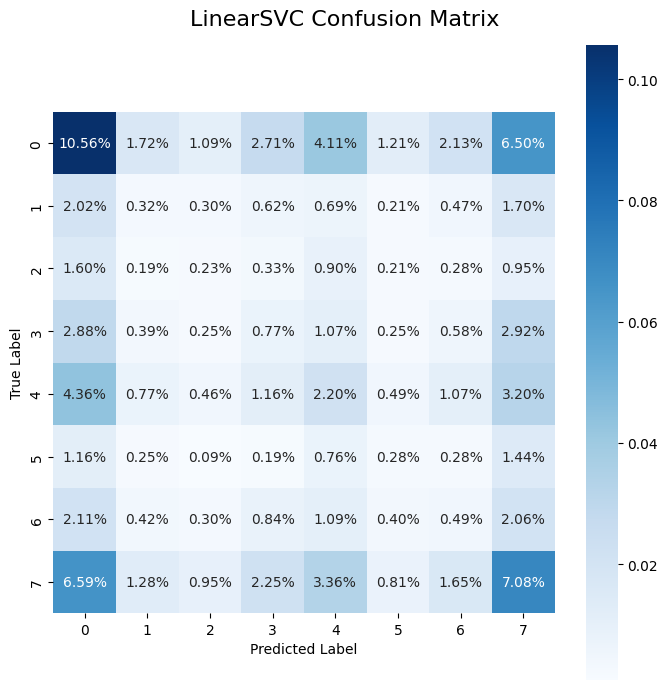

In [12]:
print("LinearSVC Metrics:\n")
for metric, score in metrics.items():
  print(f"{metric.capitalize()}: {score}")

plot_cofusion_matrix(cm_data, "LinearSVC Confusion Matrix")

In [11]:
pipeline = PipelineModel.load(f"{pipelines_model_path}LinearSVC_Lemmatized")
predictions = pipeline.transform(df_test)
metrics = evaluation_metrics(predictions)
cm_data = get_confusion_matrix_data(predictions)

24/06/02 22:26:56 WARN DAGScheduler: Broadcasting large task binary with size 15.4 MiB
24/06/02 22:29:25 WARN DAGScheduler: Broadcasting large task binary with size 15.4 MiB


In [ ]:
print("LinearSVC Lemmatized Metrics:\n")
for metric, score in metrics.items():
  print(f"{metric.capitalize()}: {score}")

plot_cofusion_matrix(cm_data, "LinearSVC Lemmatized Confusion Matrix")

In [11]:
pipeline = PipelineModel.load(f"{pipelines_model_path}NaiveBayes")
predictions = pipeline.transform(df_test)
metrics = evaluation_metrics(predictions)
cm_data = get_confusion_matrix_data(predictions)

24/06/02 21:57:50 WARN DAGScheduler: Broadcasting large task binary with size 27.6 MiB
24/06/02 21:58:23 WARN DAGScheduler: Broadcasting large task binary with size 27.6 MiB
24/06/02 21:58:46 WARN DAGScheduler: Broadcasting large task binary with size 27.6 MiB
24/06/02 21:59:08 WARN DAGScheduler: Broadcasting large task binary with size 27.6 MiB
24/06/02 21:59:31 WARN DAGScheduler: Broadcasting large task binary with size 27.6 MiB
24/06/02 21:59:53 WARN DAGScheduler: Broadcasting large task binary with size 27.6 MiB
24/06/02 22:00:15 WARN DAGScheduler: Broadcasting large task binary with size 27.6 MiB
24/06/02 22:00:15 WARN DAGScheduler: Broadcasting large task binary with size 27.6 MiB


NaiveBayes Metrics:

Accuracy: 0.18031634446397188
Weightedprecision: 0.22302109517382468
Weightedrecall: 0.18031634446397188
F1: 0.1948137434455248


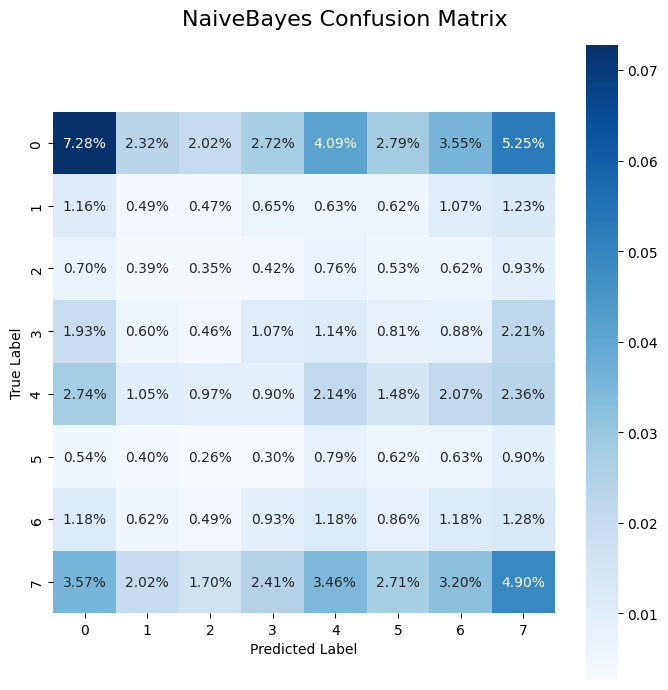

In [12]:
print("NaiveBayes Metrics:\n")
for metric, score in metrics.items():
  print(f"{metric.capitalize()}: {score}")

plot_cofusion_matrix(cm_data, "NaiveBayes Confusion Matrix")

In [11]:
pipeline_lsvc = PipelineModel.load(f"{pipelines_model_path}NaiveBayes_Lemmatized")
predictions = pipeline_lsvc.transform(df_test)
metrics = evaluation_metrics(predictions)
cm_data = get_confusion_matrix_data(predictions)

24/06/02 22:01:57 WARN DAGScheduler: Broadcasting large task binary with size 27.6 MiB
24/06/02 22:03:47 WARN DAGScheduler: Broadcasting large task binary with size 27.6 MiB


In [ ]:
print("NaiveBayes Lemmatized Metrics:\n")
for metric, score in metrics.items():
  print(f"{metric.capitalize()}: {score}")

plot_cofusion_matrix(cm_data, "NaiveBayes Lemmatized Confusion Matrix")